#  Application Lab #1 ATOC5860 Objective Analysis - bootstrapping
##### Originally coded by Prof. Kay (CU) with input from Vineel Yettella (CU ATOC Ph.D. 2018)
##### last updated January 20, 2023

### LEARNING GOALS:
1) Use an ipython notebook to read in csv file, print variables, calculate basic statistics, do a bootstrap, make histogram plot
2) Hypothesis testing and statistical significance testing using bootstrapping
3) Contrast results obtained using bootstrapping with results obtained using a t-test

### DATA and UNDERLYING SCIENCE MOTIVATION:  
In this notebook, you will analyze the relationship between Tropical Pacific Sea Surface Temperature (SST) anomalies and Colorado snowpack. Specifically, you will test the hypothesis that December Pacific SST anomalies driven by the El Nino Southern Oscillation affect the total wintertime snow accumulation at a mountain pass in Colorado.  When SSTs in the central Pacific are anomalously warm/cold, jet and precipitation locations can change. But do these atmospheric teleconnections affect total Colorado snow accumulation in the following winter? This notebook will guide you through an analysis to investigate the connections between December Nino3.4 SST anomalies (in units of °C) and the following April 1 Berthoud Pass, Colorado Snow Water Equivalence (in units of inches). Note that SWE is a measure of the amount of water contained in the snowpack.  To convert to snow depth, you multiply by ~5 (the exact value depends on the snow density).

The data have already been munged into a file called 'snow_enso_data_1936-2022.csv'. The Berthoud Pass SWE data are from: https://www.nrcs.usda.gov/wps/portal/wcc/home/snowClimateMonitoring/ and
https://wcc.sc.egov.usda.gov/nwcc/rgrpt?report=snowmonth_hist&state=CO. The Nino3.4 data are from: https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/

### First, let's load packages, read in data, look at your data

In [1]:
%matplotlib inline  
# this enables plotting within notebook

import matplotlib   # library for plotting
import matplotlib.pyplot as plt #  later you will type plt.$COMMAND
import numpy as np   # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html 

In [2]:
### Read in the data
filename='snow_enso_data_1936-2022.csv'
data=pd.read_csv(filename,sep=',')
data.head()

,Year,BerthoudPass_April1SWE_inches,Nino34_anomaly_prevDec
0,1936,22.5,-0.04
1,1937,13.4,0.63
2,1938,13.2,0.22
3,1939,18.6,-0.79
4,1940,14.5,0.05


In [3]:
### Print the data column names
print(data.columns[0])
print(data.columns[1])
print(data.columns[2])

Year
BerthoudPass_April1SWE_inches
Nino34_anomaly_prevDec


In [4]:
### Print the data values - LOOK AT YOUR DATA.  
### check out what happens when you remove .values ??
print(data['Year'].values)
print(data['BerthoudPass_April1SWE_inches'].values)
print(data['Nino34_anomaly_prevDec'].values)

"""
Removing '.values' will print the values in the form of a vertical array, similar to calling dictionary keys. 
"""

[1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022]
[22.5 13.4 13.2 18.6 14.5 15.3 13.9 14.5 12.6 13.3 14.6 16.9 16.6 16.5
 14.2 17.3 22.2 12.3 10.2 13.4 13.6 17.3 17.  17.9 15.9 11.9 18.7 11.3
 13.5 20.2  9.8 14.3 16.1 12.4 20.3 21.6 17.3 14.4 21.  15.9 14.   9.9
 20.4 18.5 22.2 10.  17.9 21.7 25.3 18.9 16.5 14.7 19.5 14.7 16.9 15.4
 15.4 18.9 17.3 17.3 22.8 16.7 16.2 12.8 16.  17.9 13.4 19.4 12.3 14.9
 20.8 16.4 19.  17.6 12.3 20.4  7.5 13.  20.6 14.6 20.6 16.4 14.  17.
 19.1 15.6 13.4]
[-0.04  0.63  0.22 -0.79  0.05  1.39  1.27 -1.24 -0.42 -0.26 -0.54  0.03
  0.18  0.38 -1.2  -1.04  0.71 -0.55  0.15

"\nRemoving '.values' will print the values in the form of a vertical array, similar to calling dictionary keys. \n"

### Question 1: Composite Loveland Pass, Colorado snowpack data.

In other words - Find April 1 SWE in all years, in El Nino years (conditioned on Nino3.4 being 1 degree C warmer than average), and in La Nina years (condition on Nino3.4 being 1 degree C cooler than average). 

Make a table showing the results.

In [5]:
### Calculate the average snowfall on April 1 at Berthoud Pass, Colorado
SWE_avg=data['BerthoudPass_April1SWE_inches'].mean()
SWE_std=data['BerthoudPass_April1SWE_inches'].std()
N_SWE=len(data.BerthoudPass_April1SWE_inches)
print(f'Average SWE (inches): {np.round(SWE_avg,2)}')
print(f'Standard Deviation SWE (inches): {np.round(SWE_std,2)}')
print(f'N: {np.round(N_SWE,2)}')

Average SWE (inches): 16.24
Standard Deviation SWE (inches): 3.43
N: 87


In [6]:
### Print to figure out how to condition and make sure it is working.  Check out if new to Python.
#print(data.Nino34_anomaly_prevDec>1) ## this gives True/False
#print(data[data.Nino34_anomaly_prevDec>1])  ## where it is True, values will print

### Calculate the average SWE when it was an el nino year
SWE_avg_nino=data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'].mean()
SWE_std_nino=data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'].std()
N_SWE_nino=len(data[data.Nino34_anomaly_prevDec>1.0].BerthoudPass_April1SWE_inches)
print(f'Average SWE El Nino (inches): {np.round(SWE_avg_nino,2)}')
print(f'Standard Deviation SWE El Nino (inches): {np.round(SWE_std_nino,2)}')
print(f'N El Nino: {np.round(N_SWE_nino,2)}')

Average SWE El Nino (inches): 16.44
Standard Deviation SWE El Nino (inches): 3.29
N El Nino: 16


In [7]:
### Calculate the average SWE when it was an la nina year
SWE_avg_nina=data[data.Nino34_anomaly_prevDec<-1.0]['BerthoudPass_April1SWE_inches'].mean()
SWE_std_nina=data[data.Nino34_anomaly_prevDec<-1.0]['BerthoudPass_April1SWE_inches'].std()
N_SWE_nina=len(data[data.Nino34_anomaly_prevDec<-1.0].BerthoudPass_April1SWE_inches)
print(f'Average SWE La Nina (inches): {np.round(SWE_avg_nina,2)}')
print(f'Standard Deviation SWE La Nina (inches): {np.round(SWE_std_nina,2)}')
print(f'N La Nina: {np.round(N_SWE_nina,2)}')

Average SWE La Nina (inches): 16.19
Standard Deviation SWE La Nina (inches): 3.81
N La Nina: 16


In [8]:
"""
Implementing a table for easier data visual via Pandas Dataframe (DF)
"""

d = {'Avg SWE (units: in)': [np.round(SWE_avg,2),np.round(SWE_avg_nino,2), np.round(SWE_avg_nina,2)], 
     'SWE SD (units: in)': [np.round(SWE_std,2),np.round(SWE_std_nino,2), np.round(SWE_std_nina,2)],
     'N'  : [np.round(N_SWE,2),np.round(N_SWE_nino,2),np.round(N_SWE_nina,2)]}

df = pd.DataFrame(data=d, index=['Apr1 SWE','El Nino','La Nina'])

df

,Avg SWE (units: in),SWE SD (units: in),N
Apr1 SWE,16.24,3.43,87
El Nino,16.44,3.29,16
La Nina,16.19,3.81,16


In [9]:
N_SWE_nino

16

### Question 2: Use hypothesis testing to assess if the differences in snowpack are statistically significant. Write your hypothesis and the 5 steps you plan to apply here.

$H_0$: Snowpack <b>is</b> influenced by El Nino and La Nina

$H_1$: Snowpack <b>is not</b> influenced by El Nino and La Nina

#### Five Steps for Application:
1) Plot normal distribution of all Apr SWE snowpack
2) Bootstrap random recorded values from Apr SWE Snowpack and fill array with N Samples.
3) Calculate Mean of randomly selected values
4) Determine SD and z statistic
5) Determine probability of event; reject or accept null hypothesis.

#### General Hypothesis Testing in Lecture 2 Slide 32:
1) State the significance level, alpha

    <i> Let's use 95% interval </i>
    
    
2) State the null and alternative hypothesis.

    $H_0$: Snowpack sample mean(el nino/la nina means) <b>does not differ</b> from the population mean, the overall SWE snowpack.
    
    $H_1$: Snowpack sample mean(el nino/la nina means) <b>differs</b> from the population mean, the overall SWE snowpack.
    
    - what this is actually testing is testing the mean only, not the variance.


    by phrasing that there isn't a difference first, we can apply a two sided test. Otherwise to state there is an influence would mean we have to apply a 1 sided test. 

3) State the statistic to be used, and the assumptions req to use it

    Assume SWE distribution is normal. Use N samples equivalent to recorded El Nino and La Nina values to estimate the true standard deviation (sigma) from the sample SD (s) via T-Test. OR use bootstrapping to determine whether the sample el nino/la nina means deviate from the overall population boot-strapped means. 
    
4) State the critical region

<i> If this was going to be a t-test (which it isn't in this case): </i>

    Using a 2-sided t-test(before we looked at the data, we didn't know what to expect from El Nino and La Nina years) we must have the following relationship to reject the null hypothesis. 
    
    With knowledge that N=16, $\nu = 16-1 = 15$
    
    The critical value can be found via lookup table or with a python function. 

<i> But because we are bootstrapping, the critical region is stated as: </i>

    The el nino means are not within the 95% confidence interval within the bootstrap means. 


5) Evaluate the statistic and state conclusion.
<i> In terms of t-test this is: </i>
$t=\frac{mean_{population} - mean_{sample}}{\frac{\sigma}{\sqrt{N-1}}}$

in terms of this equation this is:

$t=\frac{mean_{SWE} - mean_{random en,ln}}{\frac{\sigma}{\sqrt{16-1}}}$


Bootstrapping step five below. (update this later)

### Question 3: Let's bootstrap to evaluate your hypothesis about the influence of ENSO on Colorado Snow!!

Instructions for bootstrap:  Say there are N years with El Nino conditions. Instead of averaging the Loveland SWE in those N years, randomly grab N Loveland SWE values and take their average.  Then do this again, and again, and again 1000 times.  In the end you will end up with a distribution of SWE averages in the case of random sampling, i.e., the distribution you would expect if there was no physical relationship between Nino3.4 SST anomalies and Loveland Pass SWE.  

-Plot a histogram of this distribution and provide basic statistics describing this distribution (mean, standard deviation, minimum, and maximum).  

-Quantify the likelihood of getting your value of mean SWE by chance alone using percentiles of this bootstrapped distribution.  What is the probability that differences between the El Nino composite and all years occurred by chance? What is the probability that differences between the La Nina composite and all years occurred by chance?

Test the sensitivity of the results obtained in 2) by changing the number of bootstraps, the statistical significance level, or the definition of El Nino/La Nina (e.g., change the temperature threshold so that El Nino is defined using a 0.5 degree C temperature anomaly or a 3 degree C temperature anomaly).    In other words, TINKER and learn something about the robustness of your conclusions.  

In [10]:
### Bootstrap!!  Generate random samples of size N_SWE_nino and N_SWE_nina.  Do it once to see if it works.
P_random=np.random.choice(data.BerthoudPass_April1SWE_inches,N_SWE_nino)
print(P_random)  ## LOOK AT YOUR DATA

[20.3 13.2 18.9 18.6 17.6 16.1 14.6 17.3 14.7 10.  13.9 13.4 15.9 21.6
 21.  12.3]


In [24]:
N_SWE_nino

16

#### Notes:

np.random.choice(a, size=None, replace=True, p=None)


Parameters:

<b>a</b>: 1-D array-like or int

<b>size</b>: int or tuple of ints, output shape (optional)
replace: boolean (T/F), optional. Default to True so that a can be selected multiple times. 

<b>p</b>: 1-D array-like, optional. Probabilities asw each entry in a. If not given, assumes uniform distribution. 

In this case:

<i>P_random=np.random.choice(data.BerthoudPass_April1SWE_inches,N_SWE_nino)</i>

<b>a</b>: <i> data.BerthoudPass_April1SWE_inches </i>

<b>size</b>: <i> N_SWE_nino </i> or <i> N_SWE_nina </i>, doesn't matter because it justs needs the shape to be the same length of smaples in NSWE nino/nina

In [26]:
P_Bootstrap.shape

(1000, 16)

In [11]:
### Now Bootstrap Nbs times to generate a distribution of randomly selected mean SWE.
Nbs=1000 #this tells us to bootstrap 1000 times. 

## initialize array
P_Bootstrap=np.empty((Nbs,N_SWE_nino)) #initialize empty array to fill in bootstrapped samples

## loop over to fill in array with randomly selected values
for ii in range(Nbs):
    P_Bootstrap[ii,:]=np.random.choice(data.BerthoudPass_April1SWE_inches,N_SWE_nino)

## Calculate the means of your randomly selected SWE values.
P_Bootstrap_mean=np.mean(P_Bootstrap,axis=1)
print(len(P_Bootstrap_mean))  ## check length to see if you averaged across the correct axis
print(np.shape(P_Bootstrap_mean)) ## another option to look at the dimensions of a variable

P_Bootstrap_mean_avg=np.mean(P_Bootstrap_mean)
print(P_Bootstrap_mean_avg)
P_Bootstrap_mean_std=np.std(P_Bootstrap_mean)
print(P_Bootstrap_mean_std)
P_Bootstrap_mean_min=np.min(P_Bootstrap_mean)
print(P_Bootstrap_mean_min)
P_Bootstrap_mean_max=np.max(P_Bootstrap_mean)
print(P_Bootstrap_mean_max)

1000
(1000,)
16.249493750000003
0.823918287983364
14.075
19.26875


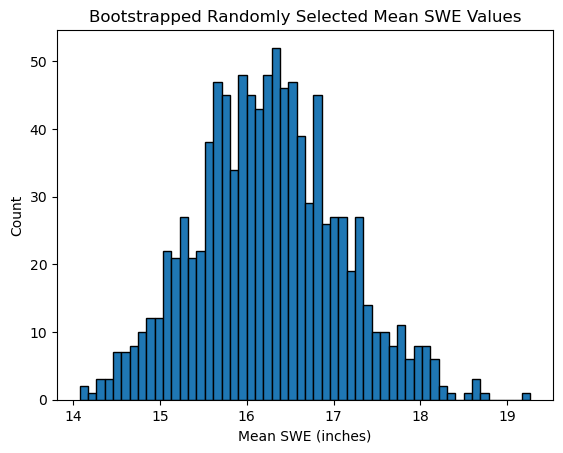

In [12]:
### Use matplotlib to plot a histogram of the bootstrapped means to compare to the conditioned SWE mean
binsize=0.1
min4hist=np.round(np.min(P_Bootstrap_mean),1)-binsize
max4hist=np.round(np.max(P_Bootstrap_mean),1)+binsize
nbins=int((max4hist-min4hist)/binsize)

plt.hist(P_Bootstrap_mean,nbins,edgecolor='black')
plt.xlabel('Mean SWE (inches)');
plt.ylabel('Count');
plt.title('Bootstrapped Randomly Selected Mean SWE Values');

#### Barnes Equation, P15, EQ 83:

$z = \frac{{\bar{X}-{\mu}_{\bar{x}}}}{{{\sigma}_{\bar{x}}}}= \frac{{\bar{X}-{\mu}}}{\frac{\sigma}{\sqrt{N}}}$

$\bar{X}$: Sample Mean

${\mu}_{\bar{X}} = {\mu}$: mean

${\sigma}_{\bar{X}} = \frac{\sigma}{\sqrt{N}}$: Std Dev


In [13]:
## What is the probability that the snowfall was lower during El Nino by chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nino
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nino=(sample_mean-population_mean)/xstd

print(f'sample_mean - El Nino: {np.round(sample_mean,2)}')
print(f'population_mean: {np.round(population_mean,2)}')
print(f'population_std: {np.round(population_std,2)}')
print(f'Z-statistic (# standard errors that the sample mean deviates from the population mean: {np.round(z_nino,2)}')
prob=(1-stats.norm.cdf(np.abs(z_nino)))*100 ##this is a one-sided test
print(f'Probability happened by chance, one-tailed test (percent): {np.round(prob,0)}%')

sample_mean - El Nino: 16.44
population_mean: 16.25
population_std: 0.82
Z-statistic (# standard errors that the sample mean deviates from the population mean: 0.24
Probability happened by chance, one-tailed test (percent): 41.0%


In [14]:
## What is the probability that the snowfall El Nino mean differs from the mean by chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nino
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nino=(sample_mean-population_mean)/xstd

print(f'sample_mean - El Nino: {np.round(sample_mean,2)}')
print(f'population_mean: {np.round(population_mean,2)}')
print(f'population_std: {np.round(population_std,2)}')
print(f'Z-statistic (# standard errors that the sample mean deviates from the population mean: {np.round(z_nino,2)}')

prob=(1-stats.norm.cdf(np.abs(z_nino)))*2*100 ##this is a two-sided test
print(f'Probability happened by chance, two-tailed test (percent): {np.round(prob,0)}%')

sample_mean - El Nino: 16.44
population_mean: 16.25
population_std: 0.82
Z-statistic (# standard errors that the sample mean deviates from the population mean: 0.24
Probability happened by chance, two-tailed test (percent): 81.0%


In [15]:
## What is the probability that the snowfall was higher during La Nina just due to chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nina
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nina=(sample_mean-population_mean)/xstd

print(f'sample_mean - La Nina: {np.round(sample_mean,2)}')
print(f'population_mean: {np.round(population_mean,2)}')
print(f'population_std: {np.round(population_std,2)}')
print(f'Z-statistic (# standard errors that the sample mean deviates from the population mean: {np.round(z_nina,2)}')
prob=(1-stats.norm.cdf(np.abs(z_nina)))*100 ##this is a one-sided test
print(f'Probability happened by chance, one-tailed test (percent): {np.round(prob,0)}%')

sample_mean - La Nina: 16.19
population_mean: 16.25
population_std: 0.82
Z-statistic (# standard errors that the sample mean deviates from the population mean: -0.07
Probability happened by chance, one-tailed test (percent): 47.0%


In [16]:
## What is the probability that the snowfall during La Nina differed just due to chance?
## Using Barnes equation (83) on page 15 to calculate probability using z-statistic
sample_mean=SWE_avg_nina
sample_N=1
population_mean=np.mean(P_Bootstrap_mean)
population_std=np.std(P_Bootstrap_mean)
xstd=population_std/np.sqrt(sample_N)
z_nina=(sample_mean-population_mean)/xstd

print(f'sample_mean - El Nino: {np.round(sample_mean,2)}')
print(f'population_mean: {np.round(population_mean,2)}')
print(f'population_std: {np.round(population_std,2)}')
print(f'Z-statistic (# standard errors that the sample mean deviates from the population mean: {np.round(z_nina,2)}')
prob=(1-stats.norm.cdf(np.abs(z_nina)))*2*100 ##this is a two-sided test
print(f'Probability happened by chance, two-tailed test (percent): {np.round(prob,0)}%')

sample_mean - El Nino: 16.19
population_mean: 16.25
population_std: 0.82
Z-statistic (# standard errors that the sample mean deviates from the population mean: -0.07
Probability happened by chance, two-tailed test (percent): 95.0%


#### Maybe you want to set up the bootstrap in another way?? 
Another bootstrapping approach is provided by Vineel Yettella (ATOC Ph.D. 2018).  
Check these out and see what you find!!

1.5436817528735636
-1.9249892241379276


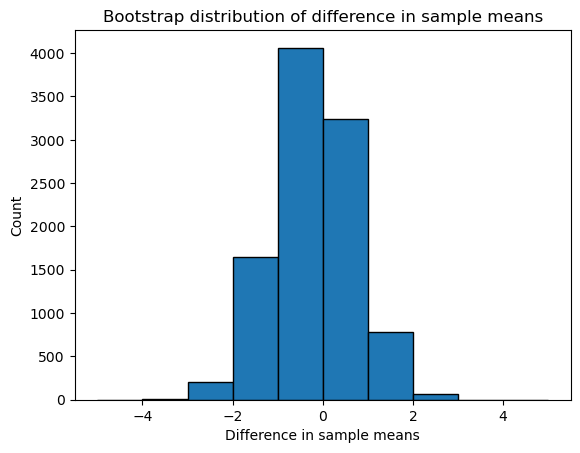

In [17]:
### Another bootstrapping strategy (provided by Vineel Yettella)
SWE = data['BerthoudPass_April1SWE_inches']
SWE_nino = data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches']

#We start by setting up a null hypothesis H0. 
#Our H0 will be that the difference in means of the two populations that the samples came from is equal to zero.
#We will use the bootstrap to test this null hypothesis.

#We next choose a significance level for the hypothesis test
alpha = 0.05

#All hypothesis tests need a test statistic.
#Here, we'll use the difference in sample means as the test statistic.
#create array to hold bootstrapped test statistic values
bootstrap_statistic = np.empty(10000)

#bootstrap 10000 times
for i in range(1,10000):
    
    #create a resample of SWE by sampling with replacement (same length as SWE)
    resample_original = np.random.choice(SWE, len(SWE), replace=True)
    
    #create a resample of SWE_nino by sampling with replacement (same length as SWE_nino)
    resample_nino = np.random.choice(SWE_nino, len(SWE_nino), replace=True)
    
    #Compute the test statistic from the resampled data, i.e., the difference in means
    bootstrap_statistic[i] = np.mean(resample_original) - np.mean(resample_nino)

#Let's plot the distribution of the test statistic
plt.hist(bootstrap_statistic,[-5,-4,-3,-2,-1,0,1,2,3,4,5],edgecolor='black')
plt.xlabel('Difference in sample means')
plt.ylabel('Count')
plt.title('Bootstrap distribution of difference in sample means')

#Create 95% CI from the bootstrapped distribution. The upper limit of the CI is defined as the 97.5% percentile
#and the lower limit as the 2.5% percentile of the boostrap distribution, so that 95% of the 
#distribution lies within the two limits

CI_up = np.percentile(bootstrap_statistic, 100*(1 - alpha/2.0))
CI_lo = np.percentile(bootstrap_statistic, 100*(alpha/2.0))

print(CI_up)
print(CI_lo)

#We see that the confidence interval contains zero, so we fail to reject the null hypothesis that the difference
#in means is equal to zero

### Question 3: Do you get the same result when you use a t-test?

Check your assumptions for the t-test and understand what is "under the hood" of your python coding.

In [18]:
## Apply a t-test to test the null hypothesis that the means of the two samples are the same 
## at the 95% confidence level.  Is this a one-sided or two-sided test??  Does it match what you got above??

## Calculate the t-statistic using the Barnes Notes - Compare a sample mean and a population mean.
## Barnes Eq. (96)
N=len(data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'])
print(f'N: {N}')
sample_mean=np.mean(data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'])
print(f'sample_mean: {np.round(sample_mean)}')
sample_std=np.std(data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'])
print(f'sample_std: {np.round(sample_std,2)}')
population_mean=np.mean(data['BerthoudPass_April1SWE_inches'])

## Using Barnes equation (96) to calculate probability using the t-statistic
t=(sample_mean-population_mean)/(sample_std/(np.sqrt(N-1)))
print(f'T-statistic: {np.round(t,2)}')
prob=(1-stats.t.cdf(t,N-1))*100
print(f'Probability (percent): {np.round(prob,0)}%')

N: 16
sample_mean: 16.0
sample_std: 3.19
T-statistic: 0.25
Probability (percent): 40.0%


In [19]:
## Calculate the t-statistic using the Barnes Notes - Compare two sample means.  Equation (110)
## This is also called Welch's t-test.  See page 26 of Chapter 1 of the Barnes notes for a worked example.

sampledata1=data['BerthoudPass_April1SWE_inches']
sampledata2=data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches']

N1=len(sampledata1)
N2=len(sampledata2)
print(f'N1={N1}, N2={N2}')
sample_mean1=np.mean(sampledata1)
sample_mean2=np.mean(sampledata2)
print(sample_mean1)
print(sample_mean2)
sample_std1=np.std(sampledata1)
sample_std2=np.std(sampledata2)
print(sample_std1)
print(sample_std2)

print("T-statistic using Barnes Eq. 109/Eq. 110 - Welch's t-test:")
s=np.sqrt((N1*sample_std1**2+N2*sample_std2**2)/(N1+N2-2))
print(f's: {np.round(s,2)}')
tw=(sample_mean1-sample_mean2-0)/(s*np.sqrt(1/N1+1/N2))
print(f'tw: {np.round(tw,2)}')
prob=(1-stats.t.cdf(tw,N-1))*100
print(f'Probability (percent): {np.round(prob,0)}%')

N1=87, N2=16
16.235632183908045
16.44375
3.413562436574068
3.1894295630253375
T-statistic using Barnes Eq. 109/Eq. 110 - Welch's t-test:
s: 3.41
tw: -0.22
Probability (percent): 59.0%


In [20]:
### Always try to code it yourself to understand what you are doing.
## Word to the wise - understand what is "under the hood" of your python function...
## Wait a second - What is that stats.ttest_ind function doing???  
# Check out the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

print('Null Hypothesis: ENSO snow years have the same mean as the full record.')
t=stats.ttest_ind(data[data.Nino34_anomaly_prevDec>1.0]['BerthoudPass_April1SWE_inches'],data['BerthoudPass_April1SWE_inches'],equal_var=False)
print(f't: {np.round(t.statistic,2)}')
print(f'pvalue: {np.round(t.pvalue,2)}')

if t.statistic>t.pvalue:
    print('Can reject the null hypthesis.')
else:
    print('Cannot reject the null hypthesis.')  
    
    
# """
# Crit Value Comparison
# """

#### can also compare tstatistic to tcrit to evaluate statistical significance.

# tcrit=stats.t.ppf(0.975,nyrs-1)
# print(f'tcrit: {np.round(tcrit,2)}')

# if np.abs(tw.statistic) > np.abs(tcrit):
#     print('Can reject the null hypthesis.')
# else:
#     print('Cannot reject the null hypthesis.') 

Null Hypothesis: ENSO snow years have the same mean as the full record.
t: 0.23
pvalue: 0.82
Cannot reject the null hypthesis.


In [22]:
"""
Implementing a table for easier data visual via Pandas Dataframe (DF)
"""

d = {'sample mean': [16.44,16.22, 16.19, 16.19], 
     'population mean': [16.22,16.22,16.22,16.22],
     'population std'  : [0.82,0.82,0.82,0.82],
     'Z-statistic'  : [0.27,0.27,-0.04,-0.04],
     'Chance Prob(2-tailed test, %)'  : [39.0,79.0,49.0,97.0]}

df = pd.DataFrame(data=d, index=['El Nino 1','El Nino 2','La Nina 1','La Nina 2'])

print('Bootstrap Method')
df



# N: 16
# sample_mean: 16.0
# sample_std: 3.19
# T-statistic: 0.25
# Probability (percent): 40.0%


Bootstrap Method


,sample mean,population mean,population std,Z-statistic,"Chance Prob(2-tailed test, %)"
El Nino 1,16.44,16.22,0.82,0.27,39.0
El Nino 2,16.22,16.22,0.82,0.27,79.0
La Nina 1,16.19,16.22,0.82,-0.04,49.0
La Nina 2,16.19,16.22,0.82,-0.04,97.0


In [23]:
"""
Implementing a table for easier data visual via Pandas Dataframe (DF)
"""

d = {'sample mean': [16.0], 
     'sample std': [3.19],
     'T-Statistic'  : [0.25],
     'Chance Prob(2-tailed test, %)'  : [40.0]}

df = pd.DataFrame(data=d, index=['T-Test (N=16)'])

print('T-Test Method')
df



T-Test Method


,sample mean,sample std,T-Statistic,"Chance Prob(2-tailed test, %)"
T-Test (N=16),16.0,3.19,0.25,40.0


### SUMMARIZE WHAT YOU FOUND AND WHAT YOU LEARNED...  

Does ENSO affect total Colorado snow accumulation at Berthoud Pass, Colorado in the following winter? 

The z-test 95% confidence interval through bootstrap is 1.96. So to accept or reject the null hypothesis, we have to compare that z-statistic for that set of data. The z-statistic for all four secenarios are below the z-test confidence interval, so we cannot reject the null hypothesis. 

Looking at the t-test method, this produces a similar conclusion. 